### *cis*- and *trans*-QTL mapping with tensorQTL

This notebook provides examples for running *cis*- and *trans*-QTL mapping with tensorQTL, using open-access data from the [GEUVADIS](https://www.ebi.ac.uk/arrayexpress/experiments/E-GEUV-1/) project.

#### Requirements
An environment configured with a GPU and ~50GB of memory.

#### Test dataset

*Note: these files are provided for testing/benchmarking purposes only. They do not constitute an official release from the GEUVADIS project, and no quality-control was applied.*

Genotypes in PLINK2 format (chr18 only), and normalized expression data are available [in this repository](./data/); the full dataset is available at [gs://gtex-resources/test_data/geuvadis](https://console.cloud.google.com/storage/browser/gtex-resources/test_data/geuvadis) ([requester pays](https://cloud.google.com/storage/docs/requester-pays)).

In [2]:
import os
os.chdir('/cluster2/home/futing/Project/HiCQTL/merged/CRC53g')
import pandas as pd
import torch
import tensorqtl
import matplotlib.pyplot as plt
from tensorqtl import pgen, cis, trans, post, genotypeio
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"torch: {torch.__version__} (CUDA {torch.version.cuda}), device: {device}")
print(f"pandas: {pd.__version__}")
prefix = 'CRC'

torch: 2.6.0+cu124 (CUDA 12.4), device: cuda
pandas: 2.3.2


#### 预处理

  - https://mirrors.ustc.edu.cn/anaconda/cloud/bioconda/
  - https://mirrors.tuna.tsinghua.edu.cn/anaconda/pkgs/free/
  - https://mirrors.tuna.tsinghua.edu.cn/anaconda/cloud/pytorch/linux-64/
  - http://mirrors.tuna.tsinghua.edu.cn/anaconda/pkgs/msys2
  - http://mirrors.tuna.tsinghua.edu.cn/anaconda/pkgs/r
  - http://mirrors.tuna.tsinghua.edu.cn/anaconda/pkgs/main

In [ ]:
try:
    import rpy2.robjects as ro
    from rpy2.robjects.packages import importr
    rfunc = importr('qvalue')
except:
    rfunc = None
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
qvalue = importr("qvalue")

In [ ]:
# 用于ClipperQTL: 去掉含有NaN，重命名chr gene_id，改顺序为chr start end gene_id
expression_file = '/cluster2/home/futing/Project/HiCQTL/merged/CRC53/phenotype/CRC53.bed'
ex = pd.read_csv(expression_file, sep='\t')
filtered = ex.loc[~ex.iloc[:, 3:].isna().any(axis=1)]  # 去掉所有含有NaN的行
filtered.rename(columns={'chrom':'#chr'}, inplace=True)
filtered.loc[:,'gene_id'] = filtered.index # bin id改为gene id
filtered = filtered[['#chr', 'start', 'end', 'gene_id'] + list(filtered.columns[3:-1])]
filtered.loc[:,'#chr'] = filtered.loc[:,'#chr'].str.replace('#chr', '', regex=False)
# filtered.to_csv('./phenotype/CRC53_Aug15.bed', sep='\t', index=False)

/tmp/ipykernel_7491/1185128448.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered.rename(columns={'chrom':'#chr'}, inplace=True)
/tmp/ipykernel_7491/1185128448.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered.loc[:,'gene_id'] = filtered.index # bin id改为gene id


In [5]:
# 用于 transferQTL: 读取CRC53.bed的输入，改gene_id为id，去除chr start end
expression_file = '/cluster2/home/futing/Project/HiCQTL/merged/CRC53/phenotype/CRC53.bed'
ex = pd.read_csv(expression_file, sep='\t')
ex.rename(columns={'chrom':'chr'},inplace=True)
ex['gene']='insul'+'_'+ex.index.astype(str)
ex =ex.dropna()
ex['chr'] = ex['chr'].str.replace('chr', '', regex=False)
filtered = ex.iloc[:, list(range(0, 3)) + [56] + list(range(3, 56))]
filtered.to_csv('./phenotype/CRC53_0901.bed', sep='\t', index=False)

filtered.head()

,chr,start,end,gene,09-376,11-1026,11-1074,11-1074_Normal,11-51,11-51_Normal,...,14-91,15-1382,15-1420,15-418,15-446,16-178,16-178_Normal,SW480,DKO,HCT116
178,1,890000,895000,insul_178,0.721850,0.901089,0.839639,0.330144,0.312873,0.727936,...,0.256476,1.384033,0.912626,0.379787,0.659389,0.668441,1.320379,0.989169,0.998001,1.662335
179,1,895000,900000,insul_179,0.540577,0.595470,0.650683,0.389669,-0.254923,0.668293,...,0.210331,0.905053,0.605062,0.557428,0.368272,0.516904,0.907322,0.562468,0.891386,1.520709
180,1,900000,905000,insul_180,0.418510,0.642061,0.561610,0.451869,-0.214719,0.916896,...,-0.009144,0.866584,0.759631,0.540593,0.420482,0.781214,0.543994,0.251199,0.787745,1.590608
181,1,905000,910000,insul_181,0.497176,0.356007,0.261403,0.214934,0.068536,0.341432,...,-0.015539,0.695639,0.733940,0.361112,0.640313,0.426678,-0.188751,0.359788,0.682265,1.415113
182,1,910000,915000,insul_182,0.814550,0.834990,0.563191,0.274900,0.074303,0.271685,...,0.370163,0.901901,0.828751,0.348402,0.670816,0.333805,-0.137275,0.674101,0.779230,1.365818


#### 读入数据

In [4]:
# define paths to data
plink_prefix_path = './genotype/CRC53hard/CRC53hard'
expression_bed = './phenotype/CRC53g_0901.bed'
# covariates_file = 'genotype_pc5.eigenvec.txt'
covariates_file ='./covariate/covariate27.txt'

# load phenotypes and covariates
phenotype_df, phenotype_pos_df = tensorqtl.read_phenotype_bed(expression_bed)
covariates_df = pd.read_csv(covariates_file, sep='\t', index_col=0).T

# # PLINK reader for genotypes
pgr = pgen.PgenReader(plink_prefix_path)
genotype_df = pgr.load_genotypes()
variant_df = pgr.variant_df
phenotype_df=phenotype_df.loc[:,covariates_df.index]

/cluster2/home/futing/miniforge3/envs/tensorqtl/lib/python3.11/site-packages/tensorqtl/core.py:409: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  phenotype_df = pd.read_csv(phenotype_bed, sep='\t', index_col=3, dtype={'#chr':str, '#Chr':str})
/cluster2/home/futing/miniforge3/envs/tensorqtl/lib/python3.11/site-packages/tensorqtl/core.py:423: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  pos_df.groupby('chr', sort=False, group_keys=False).apply(lambda x: x.sort_values(['start', 'end']))


In [ ]:
# pr = genotypeio.PlinkReader(plink_prefix_path)
# # load genotypes and variants into data frames
# genotype_df = pr.load_genotypes()
# variant_df2 = pr.bim.set_index('snp')[['chrom', 'pos']]

In [ ]:
genotype_df.replace({-9: 0}, inplace=True)  # 将-9替换为0
genotype_df.loc[genotype_df.index=='rs12567639',:]

,09-376,11-1026,11-1074,11-1074_Normal,11-51,11-51_Normal,11-52,11-52_Normal,11-63,11-63_Normal,...,14-91,15-1382,15-1420,15-418,15-446,16-178,16-178_Normal,DKO,HCT116,SW480


In [6]:
genotype_df.apply(lambda x: x.value_counts(), axis=0)

,09-376,11-1026,11-1074,11-1074_Normal,11-51,11-51_Normal,11-52,11-52_Normal,11-63,11-63_Normal,...,14-91,15-1382,15-1420,15-418,15-446,16-178,16-178_Normal,DKO,HCT116,SW480
-9,660429,763370,678148,1023039,1594411,1151807,305719,10783335,537887,1261264,...,1167516,1438578,1314512,470516,11497456,630883,1007671,803116,266770,3086251
0,8323996,8328172,8299729,8122472,7888004,8056989,8560006,959114,8385500,7946631,...,8186604,7856024,7895376,8501928,428097,8420029,8203313,8056774,8395426,7241628
1,1685065,1582827,1682897,1600676,1292255,1549159,1701919,176338,1703918,1593598,...,1368578,1521951,1622742,1633630,74169,1620169,1560813,1966883,2105523,467662
2,1399691,1394812,1408407,1322994,1294511,1311226,1501537,150394,1441876,1267688,...,1346483,1252628,1236551,1463107,69459,1398100,1297384,1242408,1301462,1273640


In [39]:
variant_df.loc[variant_df.index=='rs12567639',:]

,chrom,pos,index
id,,,
rs12567639,1,820888,228


In [40]:
# 去掉所有的-9
# fil=(genotype_df == -9).sum(axis=1)
# genotype_df= genotype_df.loc[fil==0, :]
# variant_df = variant_df.loc[variant_df.index.isin(genotype.index), :]

### *cis*-QTL: nominal p-values for all variant-phenotype pairs

In [7]:
# map all cis-associations (results for each chromosome are written to file)

# all genes
cis.map_nominal(genotype_df, variant_df, phenotype_df, phenotype_pos_df, prefix, covariates_df=covariates_df)

# genes on chr18
# cis.map_nominal(genotype_df, variant_df,
#                 phenotype_df.loc[phenotype_pos_df['chr'] == '18'],
#                 phenotype_pos_df.loc[phenotype_pos_df['chr'] == '18'],
#                 prefix, covariates_df=covariates_df)

cis-QTL mapping: nominal associations for all variant-phenotype pairs
  * 53 samples
  * 523925 phenotypes
  * 32 covariates
  * 12069181 variants
  * cis-window: ±1,000,000
    ** dropping 519125 phenotypes on chrs. without genotypes
  * checking phenotypes: 4800/4800
  * Computing associations
    Mapping chromosome 22
    processing phenotype 4800/4800
    time elapsed: 0.30 min
    * writing output
done.


In [8]:
# load results
pairs_df = pd.read_parquet(f'{prefix}.cis_qtl_pairs.22.parquet')
pairs_df.head()

,phenotype_id,variant_id,start_distance,end_distance,af,ma_samples,ma_count,pval_nominal,slope,slope_se
0,insul_570035,chr22_24945107_C_T,-999894,-1004893,0.010204,1,1,0.679145,-0.316453,0.753330
1,insul_570035,chr22_24945236_A_G,-999765,-1004764,0.790000,17,23,0.179350,0.075114,0.053877
2,insul_570035,chr22_24946092_G_A,-998909,-1003908,0.102041,8,10,0.392359,-0.058770,0.067145
3,insul_570035,chr22_24946177_G_A,-998824,-1003823,0.010000,1,1,0.596940,0.521376,0.969410
4,insul_570035,chr22_24947173_G_T,-997828,-1002827,0.136364,9,9,0.767209,-0.023082,0.076864


In [9]:
variant_df.head()

,chrom,pos,index
id,,,
chr1_10420_A_G,1,10420,0
chr1_49298_T_C,1,49298,1
chr1_51479_T_A,1,51479,2
chr1_51544_G_A,1,51544,3
chr1_51884_T_C,1,51884,4


In [10]:
# phenotype的染色体分布，全都在chr22
variants=pairs_df['variant_id'].unique()
variant_df.loc[variant_df.index.isin(variants),'chrom'].value_counts()

chrom
22    121572
Name: count, dtype: int64

In [11]:
# phenotype 的分布，大多都集中
counts = pairs_df['phenotype_id'].value_counts()
print(counts)

phenotype_id
insul_574586    13236
insul_574585    13233
insul_574584    13232
insul_574587    13227
insul_574589    13218
                ...  
insul_574974     5593
insul_574975     5567
insul_574976     5527
insul_574977     5488
insul_574978     5462
Name: count, Length: 4800, dtype: int64


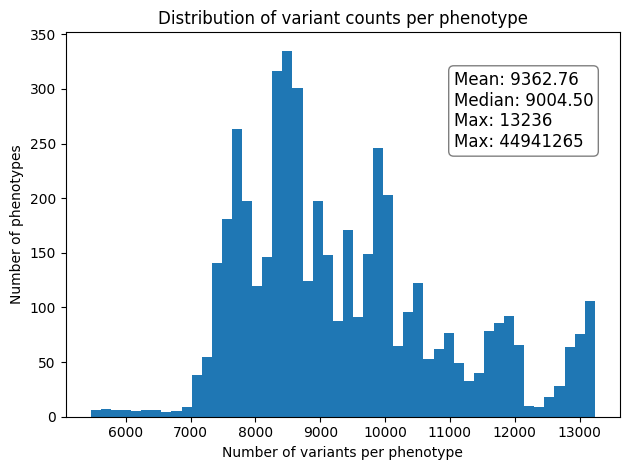

In [12]:
import matplotlib.pyplot as plt
counts.plot(kind='hist', bins=50)
plt.xlabel("Number of variants per phenotype")
plt.ylabel("Number of phenotypes")
plt.text(0.7, 0.9, f"Mean: {counts.mean():.2f}\nMedian: {counts.median():.2f}\nMax: {counts.max()}\nMax: {counts.sum()}",
		 transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
plt.title("Distribution of variant counts per phenotype")
# plt.grid(True)
plt.tight_layout()
plt.savefig(f'{prefix}.cis_qtl_pairs10k.22.hist2.png', dpi=300)

### *cis*-QTL: empirical p-values for phenotypes

In [13]:
# all genes
cis_df = cis.map_cis(genotype_df, variant_df, phenotype_df, phenotype_pos_df, covariates_df=covariates_df,
	warn_monomorphic=False)

# genes on chr18
# cis_df = cis.map_cis(genotype_df, variant_df, 
#                      phenotype_df.loc[phenotype_pos_df['chr'] == 'chr18'],
#                      phenotype_pos_df.loc[phenotype_pos_df['chr'] == 'chr18'],
#                      covariates_df=covariates_df, seed=123456)
# compute q-values (in practice, this must be run on all genes, not a subset)
post.calculate_qvalues(cis_df, fdr=0.1, qvalue_lambda=0.85)

cis-QTL mapping: empirical p-values for phenotypes
  * 53 samples
  * 523925 phenotypes
  * 32 covariates
  * 12069181 variants
  * cis-window: ±1,000,000
    ** dropping 519125 phenotypes on chrs. without genotypes
  * checking phenotypes: 4800/4800
  * computing permutations
    processing phenotype 4800/4800
  Time elapsed: 2.73 min
done.
Computing q-values
  * Number of phenotypes tested: 4800
  * Correlation between Beta-approximated and empirical p-values: 0.9999
  * Calculating q-values with lambda = 0.850
  * Proportion of significant phenotypes (1-pi0): 0.00
  * QTL phenotypes @ FDR 0.10: 0


In [1]:
cis_df.to_csv(f'{prefix}.cis_qtl_pairs.result.csv')
# cis_df = pd.read_csv(f'{prefix}.cis_qtl_pairs.22.csv')
# cis_df.set_index(['phenotype_id'], inplace=True)

NameError: name 'cis_df' is not defined

In [31]:
cis_df.head()

,num_var,beta_shape1,beta_shape2,true_df,pval_true_df,variant_id,start_distance,end_distance,ma_samples,ma_count,af,pval_nominal,slope,slope_se,pval_perm,pval_beta,qval
phenotype_id,,,,,,,,,,,,,,,,,
insul_570035,11183,1.051157,924.612061,15.886277,0.001321,rs6004990,354768,349769,4,8,0.075472,0.000430,0.207181,0.048719,0.690731,0.685705,0.844704
insul_570036,11199,1.072953,842.425781,15.373543,0.000231,rs75933260,273244,268245,16,17,0.160377,0.000040,0.307512,0.057964,0.147585,0.151563,0.772618
insul_570037,11223,1.042824,972.231445,16.131342,0.000936,rs2103525,-512782,-517781,16,31,0.292453,0.000319,0.124888,0.028489,0.583742,0.578565,0.835079
insul_570038,11213,1.040830,967.100403,16.253365,0.001713,rs2142842,-825909,-830908,32,51,0.481132,0.000680,0.147621,0.036427,0.800520,0.797758,0.852588
insul_570039,11212,1.084700,609.103394,14.007386,0.003317,rs9608430,-42405,-47404,17,23,0.216981,0.000592,-0.168292,0.040915,0.847915,0.848963,0.860132


In [ ]:
data = cis_df['qval']

# 画柱状图
# ax = data.plot(kind="bar", figsize=(8,5))

# # 找到最大值和最小值的位置和数值
# max_idx = data.idxmax()
# min_idx = data.idxmin()
# max_val = data.max()
# min_val = data.min()

# # 在图上标注最大值
# ax.text(max_idx, max_val, f"max={max_val}", ha="center", va="bottom", color="red", fontweight="bold")

# # 在图上标注最小值
# ax.text(min_idx, min_val, f"min={min_val}", ha="center", va="top", color="blue", fontweight="bold")

plt.ylabel("Qval")
# plt.title("Bar plot with max & min annotated")
plt.tight_layout()
plt.show()

In [30]:
cis_df.qval.max(),cis_df.qval.min()

(0.8789945312625702, 0.42642162520975313)

<Axes: >

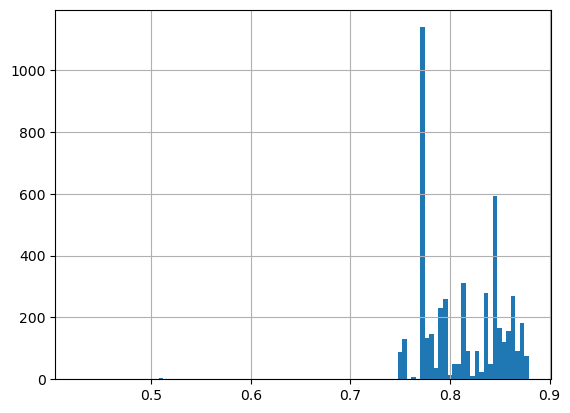

In [28]:
cis_df.qval.hist(bins=100)

### *cis*-QTL mapping: conditionally independent QTLs
This mode maps conditionally independent cis-QTLs using the stepwise regression procedure described in GTEx Consortium, 2017. The output from the permutation step (see map_cis above) is required. 

In [29]:
indep_df = cis.map_independent(genotype_df, variant_df, cis_df,
                               phenotype_df, phenotype_pos_df, covariates_df)

cis-QTL mapping: conditionally independent variants
  * 53 samples


ValueError: No significant phenotypes at FDR ≤ 0.05.

### *cis*-QTL mapping: interactions
Instead of mapping the standard linear model (p ~ g), this mode includes an interaction term (p ~ g + i + gi) and returns full summary statistics for the model. The interaction term is a tab-delimited text file or dataframe mapping sample ID to interaction value(s) (if multiple interactions are used, the file must include a header with variable names). With the run_eigenmt=True option, eigenMT-adjusted p-values are computed.

In [ ]:
cis.map_nominal(genotype_df, variant_df, phenotype_df, phenotype_pos_df, prefix,
                covariates_df=covariates_df,
                interaction_df=interaction_df, maf_threshold_interaction=0.05,
                run_eigenmt=True, output_dir='.', write_top=True, write_stats=True)

### *trans*-QTL mapping

In [ ]:
# run mapping
# to limit output size, only associations with p-value <= 1e-5 are returned
trans_df = trans.map_trans(genotype_df, phenotype_df, covariates_df, batch_size=10000,
                           return_sparse=True, pval_threshold=1e-5, maf_threshold=0.05)

In [28]:
# remove cis-associations
trans_df = trans.filter_cis(trans_df, phenotype_pos_df, variant_df, window=5000000)

In [20]:
trans_df.head()

,variant_id,phenotype_id,pval,b,b_se,af
0,chr1_51479,113324,2.660085e-06,-0.533680,0.031414,0.666667
1,chr1_51479,113325,1.921269e-09,-0.367525,0.006427,0.666667
2,chr1_51479,113352,4.744198e-08,-0.586417,0.017527,0.666667
3,chr1_51479,113965,6.395684e-06,0.595992,0.040731,0.666667
4,chr1_51479,138685,9.522360e-06,-0.370109,0.027076,0.666667


In [52]:
# trans_df.to_csv(f'{prefix}_trans_qtl_pairs.22.csv', index=False)

### 绘图

In [13]:
# 统计每个样本鉴定的SNP数量
nSNP=(genotype_df>0).sum(axis=0).sort_values(ascending=False)
# 统计每个SNP出现次数的频数
nfreq=(genotype_df>0).sum(axis=1).value_counts()

Text(0.5, 1.0, 'SNP Frequency Distribution')

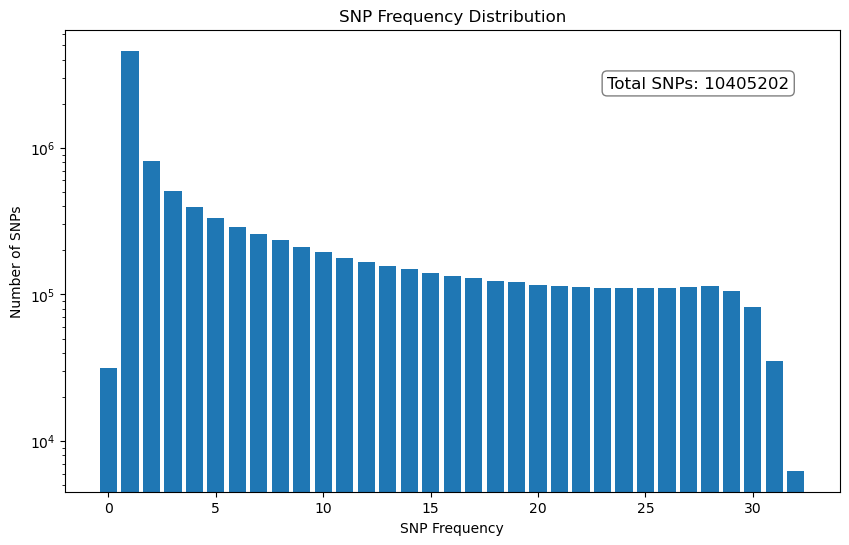

In [54]:
plt.figure(figsize=(10, 6))
plt.bar(nfreq.index, nfreq.values)
plt.yscale('log')
# plt.yticks([ 1e4, 1e5,1e6,1e7])
plt.text(0.7,0.9, f"Total SNPs: {nfreq.sum()}", transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
# plt.xticks(range(0, 14, 1))
plt.xlabel('SNP Frequency')
plt.ylabel('Number of SNPs')
plt.title('SNP Frequency Distribution')

In [12]:
# barplot
plt.figure(figsize=(10, 6))
plt.bar(nSNP.index, nSNP.values)
plt.yscale('log')
plt.xticks(rotation=90)
plt.yticks([ 1e4, 1e5,1e6,1e7])
plt.xlabel('Samples')
plt.ylabel('Number of SNPs')
plt.title('Number of SNPs per samples')

NameError: name 'nSNP' is not defined

<Figure size 1000x600 with 0 Axes>

In [ ]:
trans_df.shape,genotype_df.shape,cis_df.shape

In [36]:
pairs_df.head()

,phenotype_id,variant_id,start_distance,end_distance,af,ma_samples,ma_count,pval_nominal,slope,slope_se
0,574263,chr22_46085605_C_T,-999396,-1004395,0.5000,32,32,NaN,NaN,NaN
1,574263,rs8135478,-998896,-1003895,0.8000,2,13,0.949320,0.012576,0.195794
2,574263,chr22_46086842_G_C,-998159,-1003158,0.5000,32,32,NaN,NaN,NaN
3,574263,rs9626891,-997933,-1002932,0.5625,31,28,0.595991,-0.117615,0.218890
4,574263,chr22_46087271_G_A,-997730,-1002729,0.5000,32,32,NaN,NaN,NaN


### 手动计算

In [3]:
# phenotype_df.to_csv(f'{prefix}_phenotype_df.22.csv')
# genotype_df.to_csv(f'{prefix}_genotype_df.22.csv')
phenotype_df = pd.read_csv(f'{prefix}_phenotype_df.22.csv', index_col=0)
genotype_df = pd.read_csv(f'{prefix}_genotype_df.22.csv', index_col=0)
pairs_df = pd.read_parquet(f'{prefix}.cis_qtl_pairs.22.parquet')
cis_df = pd.read_csv(f'{prefix}_cis_qtl_pairs.22.csv', index_col=0)

In [55]:
print(f"Phenotype DataFrame shape: {phenotype_df.shape}")
print(f"Genotype DataFrame shape: {genotype_df.shape}")
print(f"Pairs DataFrame shape: {pairs_df.shape}")
print(f"Cis DataFrame shape: {cis_df.shape}")

Phenotype DataFrame shape: (539677, 32)
Genotype DataFrame shape: (10405202, 32)
Pairs DataFrame shape: (6690417, 10)
Cis DataFrame shape: (716, 17)


In [59]:
cis_df.head()

,num_var,beta_shape1,beta_shape2,true_df,pval_true_df,variant_id,start_distance,end_distance,ma_samples,ma_count,af,pval_nominal,slope,slope_se,pval_perm,pval_beta,qval
phenotype_id,,,,,,,,,,,,,,,,,
574263,3151,1.066471,576.776855,20.738218,0.000681,rs454700,592427,587428,6,8,0.875000,0.000341,0.348447,0.082949,0.300770,0.294515,0.99975
574264,3151,1.113155,474.488525,18.313345,0.001288,rs35637220,-881082,-886081,28,17,0.722222,0.000298,-0.791011,0.185912,0.420558,0.403904,0.99975
574265,3161,1.076256,411.445709,18.218555,0.004712,rs4374471,-567098,-572097,29,23,0.636364,0.001452,0.590806,0.163389,0.840016,0.838779,0.99975
574266,3164,1.092622,221.665817,13.682797,0.007830,rs4823607,67280,62281,1,1,0.972222,0.000516,0.795607,0.197195,0.801720,0.799526,0.99975
574267,3166,1.104851,288.316620,16.236423,0.004295,rs1474857,119726,114727,6,16,0.750000,0.000641,-0.410243,0.103934,0.684332,0.671096,0.99975


### actual running

In [10]:
from manual import SNPExpressionAnalyzer
import os

ModuleNotFoundError: No module named 'manual'

In [ ]:
# 04 actual running
analyzer = SNPExpressionAnalyzer()
analyzer.set_data_directly(genotype_df,phenotypedf, cismapdf)
# analyzer.preprocess_genotype()
# 批量分析
print("\n=== 批量分析 ===")
analyzer.batch_analysis(method='t_test')

# 显示汇总统计
print("\n=== 汇总统计 ===")
analyzer.get_summary_statistics()